In [1]:
# lectura y limpieza de base de datos
# ingresos de turismo de mexico

import pandas as pd

df = pd.read_csv('../../data/raw/Consulta_20251118-124432913.csv',encoding_errors='ignore',header=9)
df = df.dropna()
df = df.drop([0,1,2,3,6,7])
print(df.head())
df = pd.DataFrame([df['Ttulo'],df["Viajeros Internacionales Gasto Total, Ingresos"]]).T
df = df.iloc[:540]
df["Ttulo"]=pd.to_datetime(df["Ttulo"],format="%d/%m/%y")
df["ANIO"]=df['Ttulo'].dt.year
df["Viajeros"]=pd.to_numeric(df["Viajeros Internacionales Gasto Total, Ingresos"])
df_anual=df.groupby("ANIO")["Viajeros"].sum().reset_index()
df=df_anual.iloc[25:40]
df.to_csv("../../data/processed/turismo_ingresos/mexico.csv",index=False)

       Ttulo Viajeros Internacionales Gasto Turismo Total, Ingresos  \
8   01/01/80                                             176230       
9   01/02/80                                             197653       
10  01/03/80                                             202178       
11  01/04/80                                             169956       
12  01/05/80                                             161791       

   Viajeros Internacionales, Gasto Excursionistas Total, Ingresos  \
8                                               94613               
9                                               88412               
10                                             116686               
11                                             106648               
12                                              83381               

   Cuenta de viajeros internacionales, Ingresos, Turistas no fronterizos  \
8                                              157360                      
9     

In [2]:
# Unir ambas bases de datos de turismo

df_ch=pd.read_csv('../../data/raw/ingresos_turismo_chile.csv')
df_ch.columns = df_ch.columns.str.replace('﻿', '').str.strip()
df_ch['Año']=df_ch['Año'].astype(int)
df_ch['Ingreso en USD'] = (
    df_ch['Ingreso en USD']
    .astype(str)
    .str.replace('USD', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
    .replace('', '0')
    .astype(float)
)

df_mex=pd.read_csv('../../data/processed/turismo_ingresos/mexico.csv')
df_mex['ANIO']=df_mex['ANIO'].astype(int)
df = df_mex.rename(columns={'Viajeros':'Ingresos mex'})
df=df.merge(
    df_ch[['Año','Ingreso en USD']].rename(columns={'Año':'ANIO','Ingreso en USD':'Ingresos ch'}),
    on='ANIO',
    how='inner'
)


In [3]:
# Añadir infraestructura

df_inf_ch=pd.read_csv('../../data/raw/infraestructura_chile.csv')
df_inf_ch.columns = df_inf_ch.columns.str.replace('﻿', '').str.strip()
df_inf_ch['Año']=df_inf_ch['Año'].astype(int)
df_inf_ch['FBKF (mill USD)'] = (
    df_inf_ch['FBKF (mill USD)']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)
df_inf_ch=df_inf_ch[['Año','FBKF (mill USD)']].rename(columns={'Año':'ANIO','FBKF (mill USD)':'inf ch'})
df_inf_ch['inf ch']=df_inf_ch['inf ch']*1e6
df=df.merge(df_inf_ch,on='ANIO',how='inner')


In [4]:
df_inf_mex=pd.read_csv('../../data/raw/infraestructura_mexico.csv')
df_inf_mex.columns = df_inf_mex.columns.str.replace('﻿', '').str.strip()
df_inf_mex['Año']=df_inf_mex['Año'].astype(int)
df_inf_mex['Gasto (mmdp)'] = (
    df_inf_mex['Gasto (mmdp)']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)
df_inf_mex=df_inf_mex[['Año','Gasto (mmdp)']].rename(columns={'Año':'ANIO','Gasto (mmdp)':'inf mex'})
df_inf_mex['inf mex']=df_inf_mex['inf mex']*1e9
df=df.merge(df_inf_mex,on='ANIO',how='inner')


In [5]:
# Conversiones

tasas=pd.read_csv('../../data/processed/turismo_ingresos/tasas_cambio.csv')
df=df.merge(tasas,on='ANIO',how='inner')
df['inf mex']=df['inf mex']*df['MXN_to_USD']
df=df.sort_values('ANIO').reset_index(drop=True)
df=df[['ANIO','Ingresos mex','Ingresos ch','inf ch','inf mex']]


In [6]:
# Cambios 
df['dI/dt (ch)']=df['Ingresos ch'].diff().fillna(0)
df['dI/dt (mex)']=df['Ingresos mex'].diff().fillna(0)
df['dT/dt (ch)']=df['inf ch'].diff().fillna(0)
df['dT/dt (mex)']=df['inf mex'].diff().fillna(0)

In [7]:
# mandarlo todo a un csv

df.to_csv('../../data/processed/turismo_ingresos/unified.csv',index=False)

In [8]:
# Modelacion para Mexico
import statsmodels.api as sm

# Turismo
dfmex=pd.read_csv('../../data/processed/poblaciones/mexico.csv').iloc[3:18].reset_index()
pob_mex=dfmex['Poblacion adultos mayores (65+)']
X_T=pd.DataFrame({
    'poblacion': pob_mex.values,
    'ingresos': df['Ingresos mex'].values,
    'infra': df['inf mex'].values
})
X_T=sm.add_constant(X_T,prepend=False)
Y_T=df['dT/dt (mex)']
modelo_T=sm.OLS(Y_T,X_T).fit()
print(modelo_T.summary())

# Ingresos

X_I=df[['inf mex','Ingresos mex']]
Y_I=df['dI/dt (mex)']
#X_I=sm.add_constant(X_I,prepend=False)
modelo_I=sm.OLS(Y_I,X_I).fit()
print(modelo_I.summary())




                            OLS Regression Results                            
Dep. Variable:            dT/dt (mex)   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     2.325
Date:                Wed, 19 Nov 2025   Prob (F-statistic):              0.131
Time:                        11:37:16   Log-Likelihood:                -362.97
No. Observations:                  15   AIC:                             733.9
Df Residuals:                      11   BIC:                             736.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
poblacion  -8150.2579   9862.038     -0.826      0.4

In [9]:
# Graficacion

import numpy as np
import matplotlib.pyplot as plt

def sistema_edos(t, y):
    # y = [J, A, E, T, I]
    jt, at, et, Tt, it = y

    # COEFICIENTES modelo poblacion
    c1 = -0.0085  # tasa de natalidad
    c2 = -0.0207  # tasa de mortalidad jóvenes
    #const1= -2.161e+06
    tj=0.0359
    c3 = -0.0036  # tasa de mortalidad adultos (positiva)
    #const2=-3.146e+07
    ta=-0.0002
    c4 =  -0.0344 # tasa de mortalidad mayores
    #const3=-1.404e+06

    a1=8150.2579
    a2=-1246.9443
    a3=-0.1564
    const4=3.223e+10
    a4=7.916e-06
    a5=-0.0930
    #const5=-3.669e+06
    

    # ECUACIONES Poblacion
    dyJ = c1*at-c2*jt#+const1
    dyA = tj*jt-c3*at#+const2
    dyE = ta*at-c4*et#+const3

    # Ecuaciones Economico

    dyT=a1*et+a2*it+a3*Tt+const4
    dyI=a4*Tt+a5*it#+const5

    return [dyJ, dyA, dyE, dyT, dyI]

def RK4(func, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    n = len(t_values)
    y_values = np.zeros((n, len(y0)), dtype=float)
    y_values[0] = y0

    for i in range(1, n):
        k1 = np.array(func(t_values[i-1], y_values[i-1]))
        k2 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k1/2))
        k3 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k2/2))
        k4 = np.array(func(t_values[i-1] + h,   y_values[i-1] + h*k3))
        y_values[i] = y_values[i-1] + h*(k1 + 2*k2 + 2*k3 + k4)/6

    return t_values, y_values

# y0 = [J, A, E, T, I] en 2005
y0 = [27858970,65630336,5953231, 46244310000.0, 11803409.721]
t0, tf, h = 0, 15, 0.01

t, y = RK4(sistema_edos, y0, t0, tf, h)


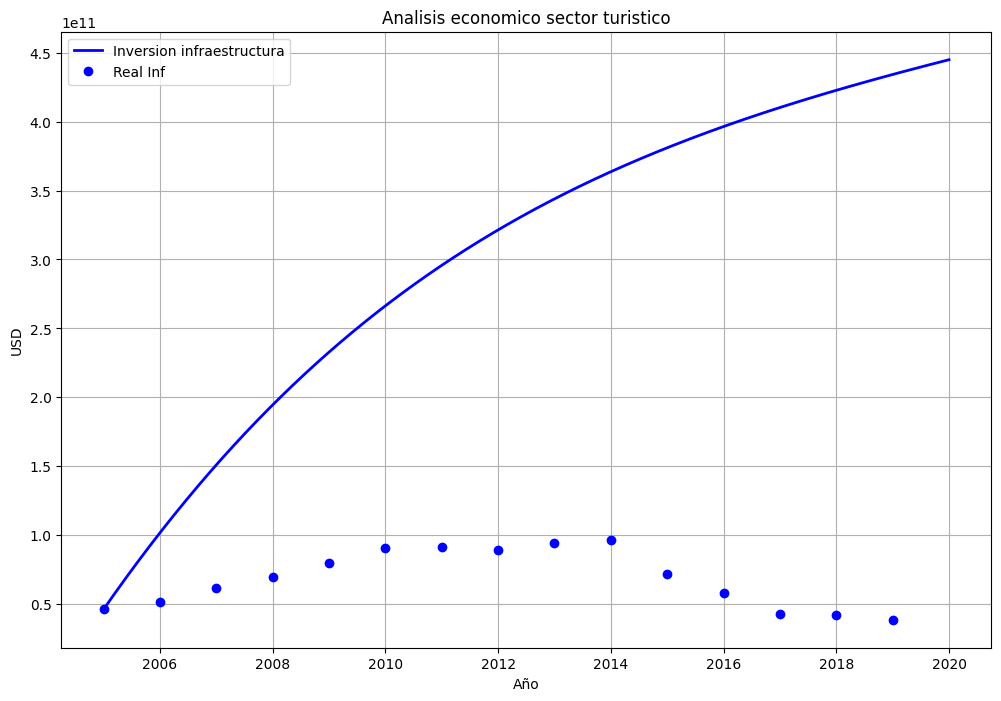

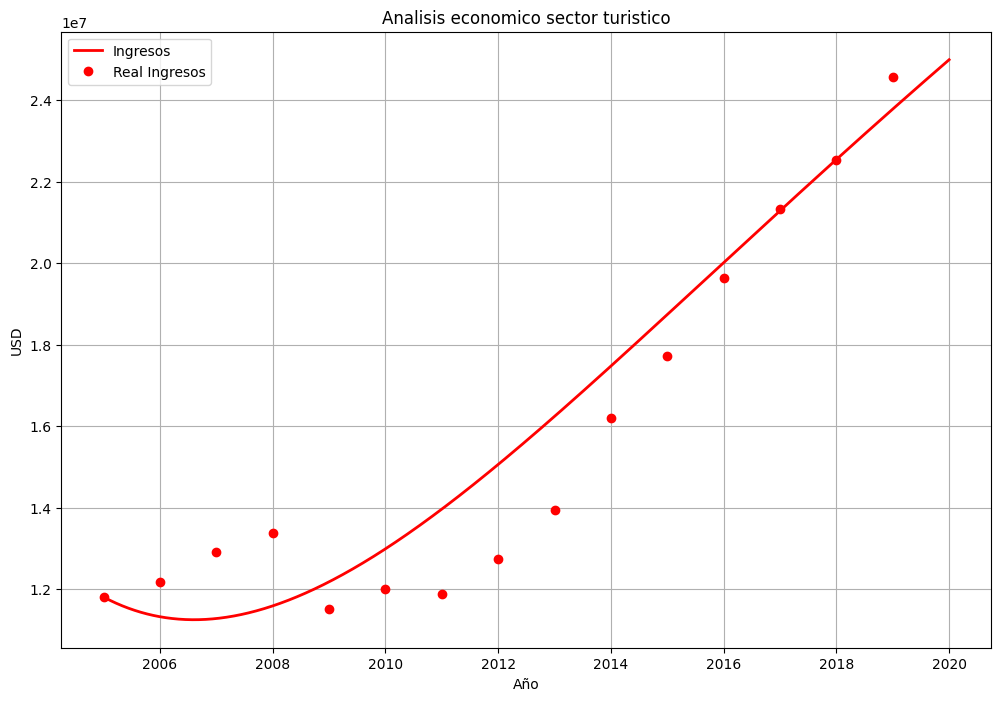

In [10]:
# Graficacion

years = 2005 + t
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Modelo
ax.plot(years, y[:, 3], 'b-', linewidth=2, label='Inversion infraestructura')

# Reales

years_real=df['ANIO']
ax.plot(years_real,df['inf mex'],'bo',markersize=6,label='Real Inf')



ax.set_title('Analisis economico sector turistico')
ax.set_xlabel('Año')
ax.set_ylabel('USD')
ax.grid(True)
ax.legend()
plt.show()

fig, bx = plt.subplots(1,1,figsize=(12,8))
bx.plot(years, y[:, 4], 'r-', linewidth=2, label='Ingresos')

bx.plot(years_real,df['Ingresos mex'],'ro',markersize=6,label='Real Ingresos')

bx.set_title('Analisis economico sector turistico')
bx.set_xlabel('Año')
bx.set_ylabel('USD')
bx.grid(True)
bx.legend()
plt.show()




In [11]:
# Modelacion chile

# Turismo
df_ch=pd.read_csv('../../data/processed/poblaciones/chile.csv').iloc[3:18].reset_index()

x_T=pd.DataFrame({
    'poblacion':df_ch['Poblacion total mayores (65+ años)'].values,
    'ingresos':df['Ingresos ch'].values,
    'inf':df['inf ch'].values
})
#x_T=sm.add_constant(x_T,prepend=False)
y_T=df['dT/dt (ch)']
modelo_T=sm.OLS(y_T,x_T).fit()
print(modelo_T.summary())

# Ingresos

x_I=df[['inf ch','Ingresos ch']]
#x_I=sm.add_constant(x_I,prepend=False)
y_I=df['dI/dt (ch)']
modelo_I=sm.OLS(y_I,x_I).fit()
print(modelo_I.summary())




                                 OLS Regression Results                                
Dep. Variable:             dT/dt (ch)   R-squared (uncentered):                   0.321
Model:                            OLS   Adj. R-squared (uncentered):              0.152
Method:                 Least Squares   F-statistic:                              1.895
Date:                Wed, 19 Nov 2025   Prob (F-statistic):                       0.184
Time:                        11:37:16   Log-Likelihood:                         -357.05
No. Observations:                  15   AIC:                                      720.1
Df Residuals:                      12   BIC:                                      722.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
def sistema_edos(t, y):
    # y = [J, A, E, T, I]
    jt, at, et, Tt, it = y

    # COEFICIENTES modelo poblacion
    c1 = -0.0085  # tasa de natalidad
    c2 = -0.0207  # tasa de mortalidad jóvenes
    #const1= -2.161e+06
    tj=0.0359
    c3 = -0.0036  # tasa de mortalidad adultos (positiva)
    #const2=-3.146e+07
    ta=-0.0002
    c4 =  -0.0344 # tasa de mortalidad mayores
    #const3=-1.404e+06

    a1=1635.4582
    a2=-472.3130
    a3=0.1790 
    #const4=3.223e+10
    a4=-0.0001
    a5=0.4089 
    #const5=-3.669e+06
    

    # ECUACIONES Poblacion
    dyJ = c1*at-c2*jt#+const1
    dyA = tj*jt-c3*at#+const2
    dyE = ta*at-c4*et#+const3

    # Ecuaciones Economico

    dyT=a1*et+a2*it+a3*Tt#+const4
    dyI=a4*Tt+a5*it#+const5

    return [dyJ, dyA, dyE, dyT, dyI]

# y0 = [J, A, E, T, I] en 2005
y0 = [3991476.0,10826184.0,1365829.0, 27235000000.0, 12106828.0]
t0, tf, h = 0, 15, 0.01

t, y = RK4(sistema_edos, y0, t0, tf, h)



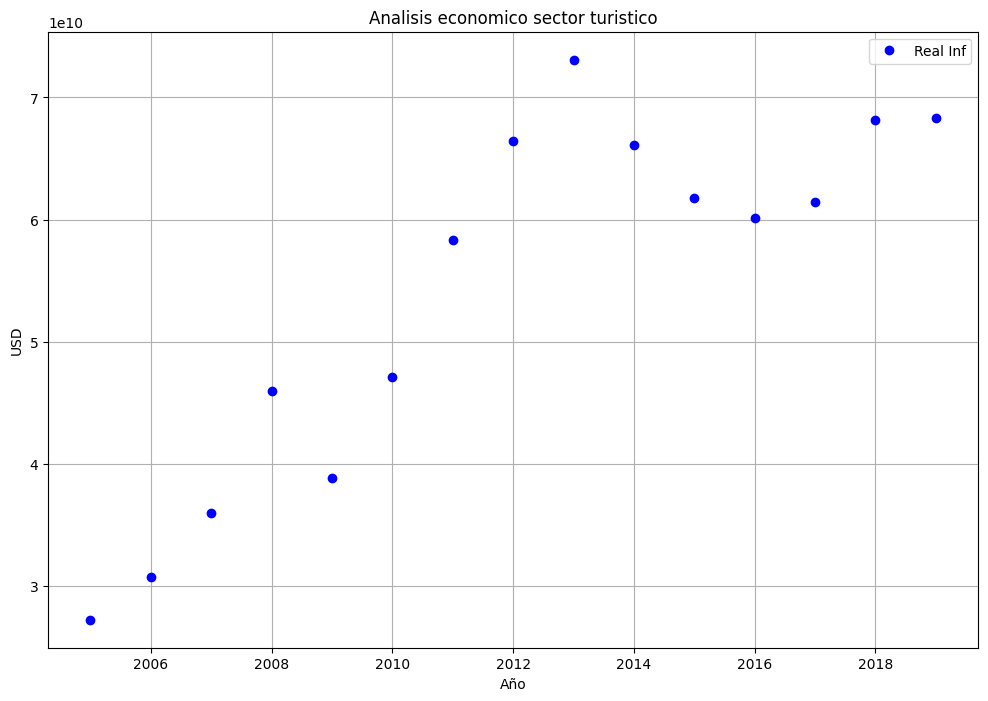

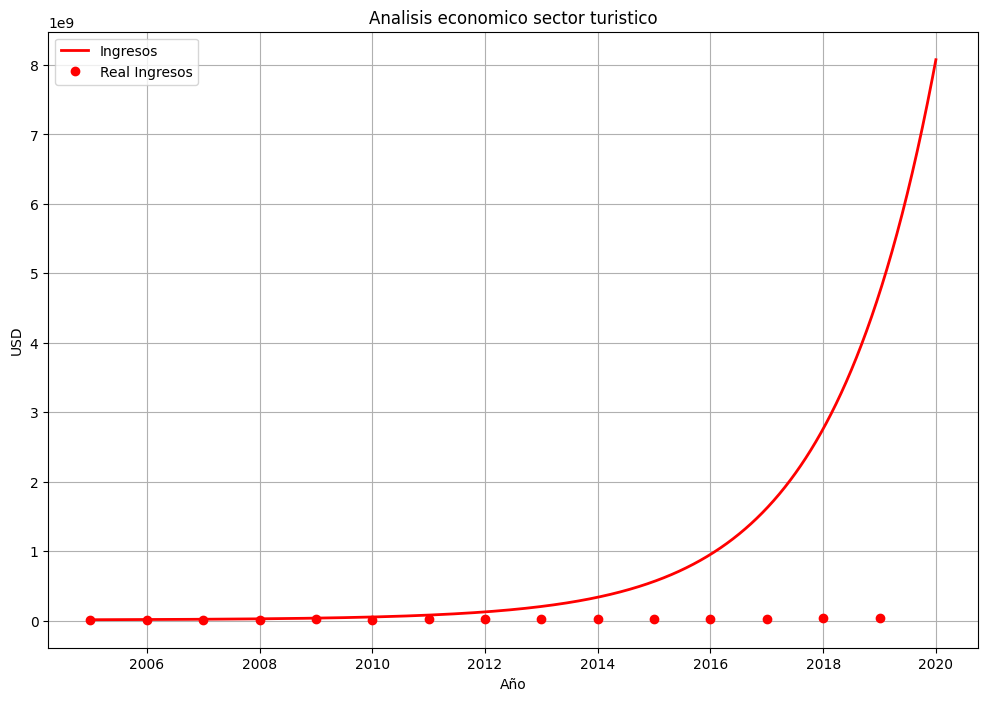

In [17]:
# Graficar

years = 2005 + t
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Modelo
#ax.plot(years, y[:, 3], 'b-', linewidth=2, label='Inversion infraestructura')

# Reales

years_real=df['ANIO']
ax.plot(years_real,df['inf ch'],'bo',markersize=6,label='Real Inf')



ax.set_title('Analisis economico sector turistico')
ax.set_xlabel('Año')
ax.set_ylabel('USD')
ax.grid(True)
ax.legend()
plt.show()

fig, bx = plt.subplots(1,1,figsize=(12,8))
bx.plot(years, y[:, 4], 'r-', linewidth=2, label='Ingresos')

bx.plot(years_real,df['Ingresos ch'],'ro',markersize=6,label='Real Ingresos')

bx.set_title('Analisis economico sector turistico')
bx.set_xlabel('Año')
bx.set_ylabel('USD')
bx.grid(True)
bx.legend()
plt.show()